# Lab Assignment 4

**Computer Vision** - Term 5, 2023

Instructor: Dr. Saumya Jetley <br>
TA: Ribhu Lahiri, Raghav Awasty


### Before Starting

Please download the FER-2013 dataset using the cell below

You will need it for the tasks that follow.

In [1]:
import gdown

!gdown "1uFKf3RHcYZVFHaejNMmz_lBgICIZf5VH&confirm=t" -O 'fer2013.zip'

Downloading...
From: https://drive.google.com/uc?id=1uFKf3RHcYZVFHaejNMmz_lBgICIZf5VH&confirm=t
To: /content/fer2013.zip
100% 101M/101M [00:00<00:00, 115MB/s] 


In [2]:
! unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from skimage import color
from skimage.transform import resize
from skimage.feature import hog

In [4]:
# Reading in the dataset
df = pd.read_csv('./fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
# Extract relevant data
x_data = pd.Series(df.pixels)
y_data = pd.Series(df.emotion)
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255 # Normalizing

In [6]:
# Reshape into 48x48 images
x_data = x_data.reshape(-1, 48, 48)
x_data.shape

(35887, 48, 48)

### Task 1: Creating histogram of Oriented Gradients (4 points)
The first task is to create the histogram of oriented gradients feature descriptor. There are two steps to it, the first is to create the oriented gradients from a given image which returns the magnitude and angle matrices. The next step then, is to use those matrices to create the histogram features.

You can refer to this blog as discussed in the lab session: https://iq.opengenus.org/object-detection-with-histogram-of-oriented-gradients-hog/

**Implement the `get_oriented_gradients` function** *(2 points)*

Use any sample image from the dataset to test out your function

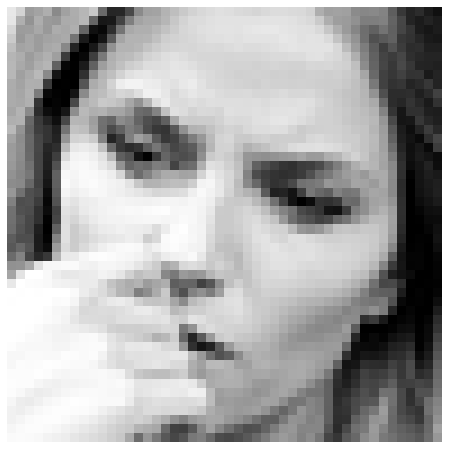

In [7]:
# Read in any image from the dataset
img = x_data[2]
plt.figure(figsize=(15, 8))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [8]:
img.shape

(48, 48)

In [9]:
import numpy as np
from scipy.ndimage.filters import convolve

<ipython-input-9-b0bcd2a306a5>:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


The gradient of image is calculated using derivative filters such as Sobel

In [10]:
img = np.array(img)
def get_oriented_gradients(img):

  sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])   # defining my sobel filters
  sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

  grad_x = convolve(img, sobel_x)  #gradients
  grad_y = convolve(img, sobel_y)
  mag = np.sqrt(grad_x**2 + grad_y**2) #magnitude 
  theta = np.arctan2(grad_y, grad_x)   #angle of the gradients
    
  return mag, theta

In [11]:
mag, theta = get_oriented_gradients(img)

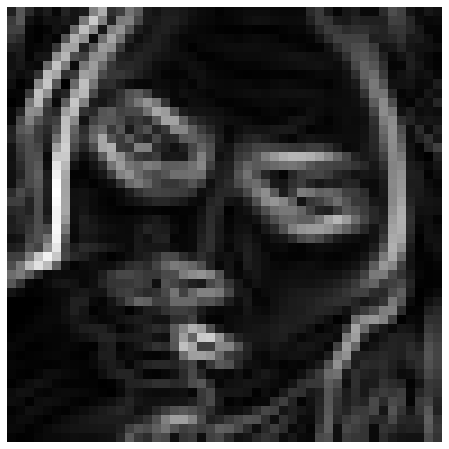

In [12]:
plt.figure(figsize=(15, 8))
plt.imshow(mag, cmap="gray")
plt.axis("off")
plt.show()

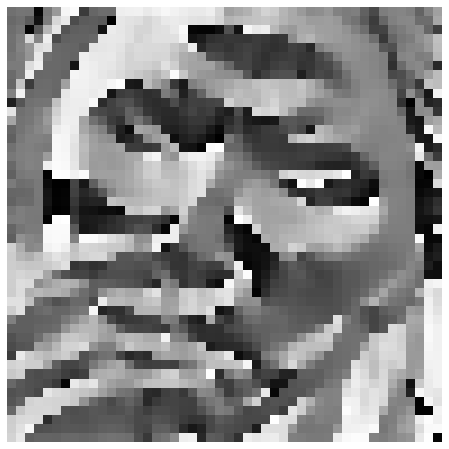

In [13]:
plt.figure(figsize=(15, 8))
plt.imshow(theta, cmap="gray")
plt.axis("off")
plt.show()

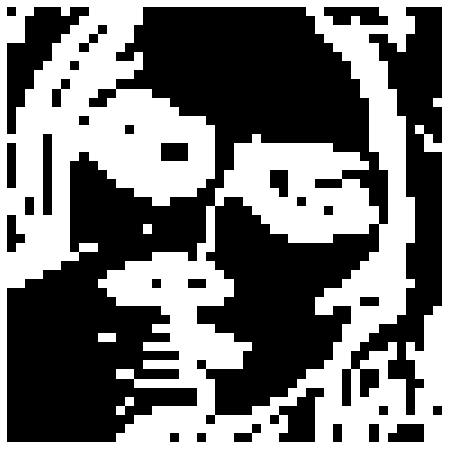

In [14]:
m_viz = (mag > 0.5).astype(float)
plt.figure(figsize=(15, 8))
plt.imshow(m_viz, cmap="gray")
plt.axis("off")
plt.show()

**Implement the `hog_features` function** *(2 points)*

Use the image, magnitudes, and angles of oriented gradients to bin them and create the HoG features to be used by our classifier

NOTE: While I have set the default value of number of bins as 9. Feel free to experiment and observe the effects of changing it on the downstream task

In [39]:
def hog_features(img, nbins=9, mag=None, theta=None):
    if mag is None or theta is None:
        mag, theta = get_oriented_gradients(img)

    cell_size = 8
    block_size = 16
    stride = 8
    n_cells_x = img.shape[1] // cell_size     # calculating number of cells in each dimension
    n_cells_y = img.shape[0] // cell_size
    histogram = np.zeros((n_cells_y, n_cells_x, nbins))
    for i in range(n_cells_y):
        for j in range(n_cells_x):
            cell_mag = mag[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            cell_theta = theta[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            hist, _ = np.histogram(cell_theta, bins=nbins, range=(-np.pi, np.pi), weights=cell_mag)
            histogram[i, j] = hist

    n_blocks_x = (n_cells_x - block_size // cell_size) // stride + 1   #normalising
    features = np.zeros((n_blocks_y, n_blocks_x, block_size // cell_size * block_size // cell_size * nbins))
    for i in range(n_blocks_y):
        for j in range(n_blocks_x):
            block_hist = histogram[i*stride:i*stride+block_size // cell_size, j*stride:j*stride+block_size // cell_size]
            block_hist = block_hist.ravel() / (np.linalg.norm(block_hist) + 1e-7)
            features[i, j] = block_hist
    features = features.ravel() # basically flattenning to 1D
    
    return features


### Task 2: Using HoG with AdaBoost Classifier (1 points)
The second task is to create an AdaBoost classifier that uses the HoG features to classify the given images into one of 7 classes representing different emotions.

**Extra Credit:** Implement the AdaBoost Classifier from scratch, i.e. without using scikit-learn (1 points)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.3, 
                                                    random_state=42)
X_train.shape

(25120, 48, 48)

In [41]:
X_train = np.array([hog_features(im) for im in X_train])
X_test = np.array([hog_features(im) for im in X_test])


In [42]:
print(X_train.shape)

(25120, 36)


In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

clf = AdaBoostClassifier(n_estimators=50)

clf.fit(X_train, y_train)

AdaBoostClassifier()

In [46]:
from sklearn.metrics import classification_report

y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.23      0.06      0.10      3486
           1       0.10      0.04      0.05       380
           2       0.18      0.02      0.03      3555
           3       0.28      0.69      0.40      6275
           4       0.24      0.25      0.24      4284
           5       0.26      0.19      0.22      2812
           6       0.24      0.10      0.14      4328

    accuracy                           0.27     25120
   macro avg       0.22      0.19      0.17     25120
weighted avg       0.24      0.27      0.21     25120



In [47]:
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.21      0.06      0.09      1467
           1       0.08      0.02      0.04       167
           2       0.17      0.02      0.03      1566
           3       0.28      0.69      0.40      2714
           4       0.22      0.22      0.22      1793
           5       0.25      0.17      0.20      1190
           6       0.23      0.10      0.14      1870

    accuracy                           0.26     10767
   macro avg       0.20      0.18      0.16     10767
weighted avg       0.23      0.26      0.20     10767

